<a href="https://colab.research.google.com/github/axiom19/Biomass/blob/master/Prediction_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install --upgrade pip

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz

# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data

In [ ]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("/content/haucs-monitoring-firebase-adminsdk-wt1pb-1291f2083e.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [ ]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
data

{'bmass_1': {'data': {'20230329_13:20:15': ['786', '785', '11308'],
   '20230329_13:31:20': ['785', '784', '11308'],
   '20230329_13:42:26': ['786', '785', '11308'],
   '20230329_13:53:38': ['786', '785', '11308'],
   '20230329_14:04:45': ['787', '786', '11308'],
   '20230329_14:15:58': ['787', '786', '11308'],
   '20230329_14:27:04': ['786', '785', '11308'],
   '20230329_14:38:19': ['786', '785', '11308'],
   '20230329_14:49:25': ['786', '785', '11308'],
   '20230329_15:00:37': ['786', '785', '11308'],
   '20230329_15:11:44': ['786', '785', '11308'],
   '20230329_15:22:50': ['786', '785', '11308'],
   '20230329_15:33:58': ['786', '785', '11308'],
   '20230329_15:45:11': ['786', '785', '11308'],
   '20230329_15:56:18': ['786', '785', '11308'],
   '20230329_16:07:26': ['786', '785', '11308'],
   '20230329_16:18:35': ['786', '785', '11308'],
   '20230329_16:29:43': ['786', '786', '11308'],
   '20230329_16:40:49': ['786', '785', '11308'],
   '20230329_16:51:57': ['786', '785', '11308'],
 

# Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [ ]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        if "T" in i or "-" in i:
          i = i.replace("T","_")
          i = i.replace("-","")
        i_dt = datetime.strptime(i, "%Y%m%d_%H:%M:%S")
        # i_dt = datetime.fromisoformat(date)
        
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return dt

#time
example = datetime.fromisoformat("2023-03-12T01:30:05")
#time zone aware current time
# example_aware = to_datetime([str(example)])[0]

print("unaware time: ", example)
# print("aware time: ", example_aware)

print("unaware timestamp", example.timestamp())
# print("aware timestamp", example_aware.timestamp())

unaware time:  2023-03-12 01:30:05
unaware timestamp 1678584605.0


# Local Data
Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.
<table>
<tr> <th>Event</th>	<th>Description</th>	<th>Value</th></tr>
<tr> <td>i</td>	<td>installed in a tank</td>	<td>tank installed in</td></tr>
<tr> <td>r</td>	<td>removed from a tank</td>	<td>tank removed from</td></tr>
<tr> <td>c</td>	<td>debris cleaned from sensor</td>	<td>N/A</td></tr>
<tr> <td>f</td>	<td>sensor failure leading to missing data</td>	<td>N/A</td></tr>
</table>

In [ ]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_log.csv')
df_harvest['datetime'] = to_datetime(df_harvest.Date)
print(df_anomaly.head())
print("\n", df_harvest.head())

                  Date  ID Event  Value                  datetime
0  2023-04-11T09:00:00   1     r    1.0 2023-04-11 09:00:00-04:00
1  2023-04-11T13:30:00   1     i    2.0 2023-04-11 13:30:00-04:00
2  2023-04-12T17:30:00   3     f    NaN 2023-04-12 17:30:00-04:00
3  2023-04-13T10:00:00   2     r    1.0 2023-04-13 10:00:00-04:00
4  2023-04-13T18:00:00   2     i    2.0 2023-04-13 18:00:00-04:00

                   Date  ID  Before  After                  datetime
0  2023-02-03T12:00:00   3   39.71  22.11 2023-02-03 12:00:00-05:00
1  2023-02-09T12:00:00   3   36.90  22.11 2023-02-09 12:00:00-05:00
2  2023-02-16T12:00:00   3   46.30  22.11 2023-02-16 12:00:00-05:00
3  2023-02-22T12:00:00   3   43.01  22.11 2023-02-22 12:00:00-05:00
4  2023-03-02T12:00:00   3   44.40  22.11 2023-03-02 12:00:00-05:00


# Processing Sensor Data

In [ ]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

In [ ]:
print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
print("bm3: ", bm3.s_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

bm1:  2023-04-27 10:33:59-04:00   383   350   1142
bm2:  2023-04-27 10:35:16-04:00   779   781   65480
bm3:  2023-04-27 10:35:38-04:00   779   781   65480
bm4:  2023-04-27 10:37:42-04:00   781   11   23872
bm5:  2023-04-27 10:41:01-04:00   781   717   2059


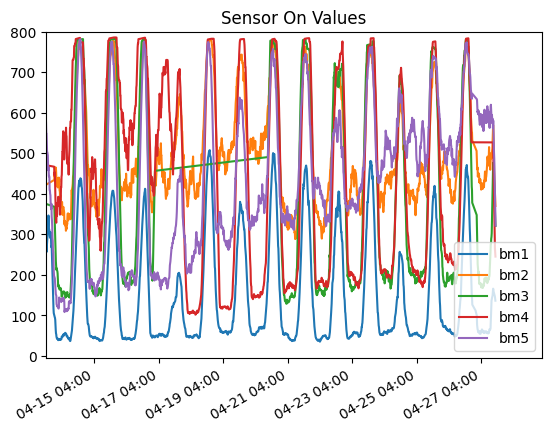

In [ ]:
# checking laser on values for all sensors
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)


lower = datetime(2023, 4, 13, hour=16)
#plot
plt.figure()
plt.plot(bm1.d_dt, moving_average(bm1.on, 20))
plt.plot(bm2.d_dt, moving_average(bm2.on, 20))
plt.plot(bm3.d_dt, moving_average(bm3.on, 20))
plt.plot(bm4.d_dt, moving_average(bm4.on, 20))
plt.plot(bm5.d_dt, moving_average(bm5.on, 20))
plt.xlim(left=lower)
plt.ylim(top=800)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

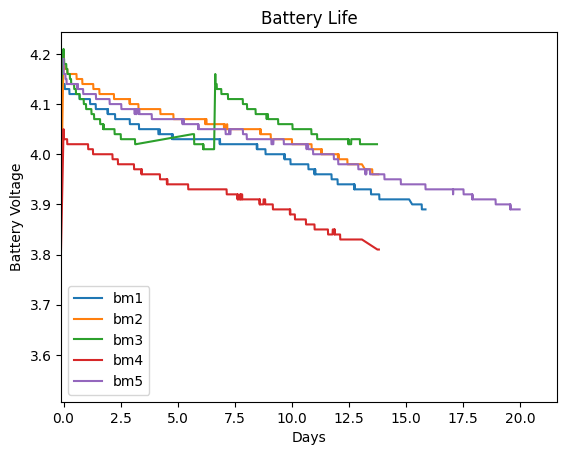

In [ ]:
# checking battery life
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[1633]
bm2_start = bm2_t[812]
bm3_start = bm3_t[723]
bm4_start = bm4_t[755]
bm5_start = bm5_t[0]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
plt.show()

Int64Index([0, 1, 14], dtype='int64')
r
i
c


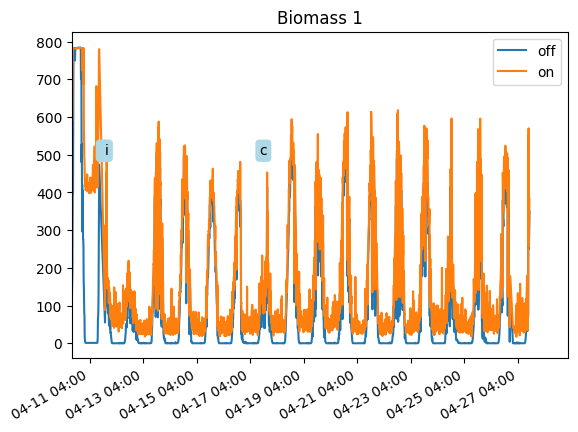

In [ ]:
id = 1
bmx = bm1
lower = datetime(2023, 4, 10, hour=12)
#plot
plt.figure()
plt.plot(bmx.d_dt, bmx.off)
plt.plot(bmx.d_dt, bmx.on)
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Biomass " + str(id))
plt.legend(['off', 'on'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

#plot anomalies 
bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
print(bmx_anomalies)
for i in bmx_anomalies:
    print(df_anomaly.Event[i])
    text = str(df_anomaly.Event[i])
    pos = df_anomaly.datetime[i]
    plt.text(pos, 500, text,
                bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
plt.show()

#Deleting Data from Firebase
WARNING: this action will permanently alter the data in Firebase.

In [ ]:
# #select sensor and data or status path
# del_path = '/bmass_5/data'
# del_node = db.reference(del_path)
# #select start date for delete 
# del_start = datetime(2023, 4, 13, hour=10, minute=0)
# #select end date for delete
# del_end = datetime(2023, 4, 13, hour=18, minute=0)

# del_data = del_node.get()
# del_data_dt = []
# print("Deleting the Following Nodes: ", del_path)
# for i in del_data:
#     i_dt = datetime.fromisoformat(i)
#     if (del_start <= i_dt <= del_end):
#         print(i)
#         del_data_dt.append(i)
        
# #uncomment the following section to delete
# print("Should these nodes be deleted? (y/n)")
# # if (input('permanently delete (y/n): ') == 'y'):
# #     for i in del_data_dt:
# #         del_point = del_path + '/' + i
# #         del_point = db.reference(del_point)
# #         del_point.delete()

# Prediction Models 


In [ ]:
pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.7/872.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.2 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.3-py3-none-any.whl size=111282 sha256=4b6de65027c82c4303041318ea7750a690b4a446427c8db92a653e8c947389eb
  Stored in directory: /root/.cache/pip/wheels/84/00/1e/d325b2af33506fa2311b60f263312157ea4485acaaf91de969
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=360adde09c8818d1939a4655bfa6fef86a7cdfd5439bed2ff2f2adb65929f732
 

# USING GOLAY VALUES FOR PREDICTION

In [ ]:
dates = pd.to_datetime(bm1.d_dt)
values = bm1.g
df = pd.DataFrame({'ds': dates, 'y': values})

In [ ]:
# start_time = '23:00:00'
# end_time = '04:00:00'

# convert the 'ds' column to datetime type
# df['ds'] = pd.to_datetime(df['ds'])
# df = df.set_index('ds')
# # filter the data between 11pm and 4am
# filtered_data = df.set_index('ds').between_time(start_time, end_time)

# # display the filtered data
# print(filtered_data)

In [ ]:
df

,ds,y
0,2023-03-29 13:20:15-04:00,11308
1,2023-03-29 13:31:20-04:00,11308
2,2023-03-29 13:42:26-04:00,11308
3,2023-03-29 13:53:38-04:00,11308
4,2023-03-29 14:04:45-04:00,11308
...,...,...
3603,2023-04-27 09:49:18-04:00,622
3604,2023-04-27 10:00:28-04:00,611
3605,2023-04-27 10:11:38-04:00,666
3606,2023-04-27 10:22:49-04:00,893


# Using data only after 11th April without filtering Night-time 

In [ ]:
start_date = "2023-04-12"
mask = (df['ds'] > start_date)
df_clean = df.loc[mask]

In [ ]:
df_clean

,ds,y
1657,2023-04-12 00:08:33-04:00,1992
1658,2023-04-12 00:19:41-04:00,1882
1659,2023-04-12 00:30:55-04:00,2302
1660,2023-04-12 00:41:54-04:00,1808
1661,2023-04-12 00:53:20-04:00,2083
...,...,...
3603,2023-04-27 09:49:18-04:00,622
3604,2023-04-27 10:00:28-04:00,611
3605,2023-04-27 10:11:38-04:00,666
3606,2023-04-27 10:22:49-04:00,893


In [ ]:
# convert the 'ds' column to datetime type
df_clean['ds'] = pd.to_datetime(df_clean['ds'])
df_clean = df_clean.set_index('ds')

<ipython-input-20-9f50620fadf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ds'] = pd.to_datetime(df_clean['ds'])


In [ ]:
pip install scalecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.7/872.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.9 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.3-py3-none-any.whl size=111282 sha256=d7a021d8b1f288bef8f5029a60365ed397aab1d6cc824a5fa6bc088081750461
  Stored in directory: /root/.cache/pip/wheels/84/00/1e/d325b2af33506fa2311b60f263312157ea4485acaaf91de969
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=eb037d4559efcc0251d5b4ea28cd37e1a1ccd91b7ad877442bd08e1a3a9724a7
 

In [ ]:
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [ ]:
f = Forecaster(
    y = df_clean['y'],
    current_dates= df_clean.index,
    freq='11T'
)

In [ ]:
f

Forecaster(
    DateStartActuals=2023-04-12T04:08:33.000000000
    DateEndActuals=2023-04-27T14:33:59.000000000
    Freq=11T
    N_actuals=1951
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


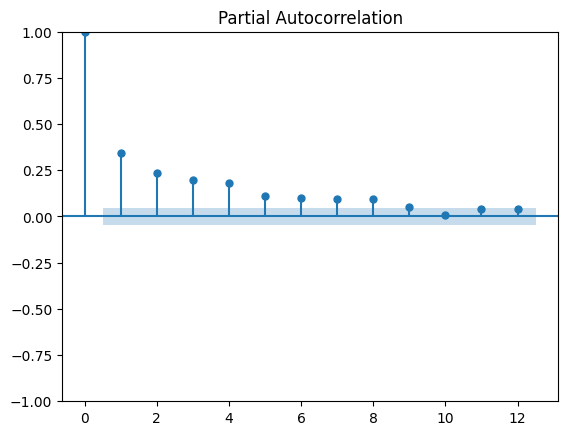

In [ ]:
f.plot_pacf(lags=12)
plt.show()

The PACF shows statistical correlation in 1 day values

# Augmented Dickey-Fuller test

This test is to see if the series is stationary or non-stationary

In [ ]:
stat, pval, _, _, _, _ = f.adf_test()

In [ ]:
print(f'Stat: {stat}')
print(f'P-value: {pval}')

Stat: -4.504744086716128
P-value: 0.0001927948356930125


As P-value is less than 0.05, the series can be assumed stationary

# ARIMA Forecasting

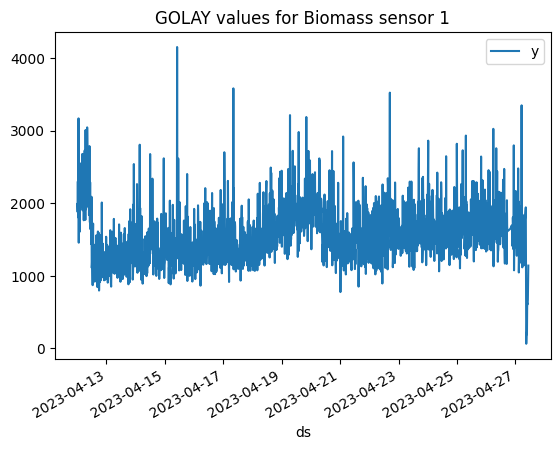

In [ ]:
df_clean.plot()
plt.title("GOLAY values for Biomass sensor 1")
plt.show()

Determine the order of the AR and MA terms (p and q) for the ARIMA model using the autocorrelation function (ACF) and partial autocorrelation function (PACF):

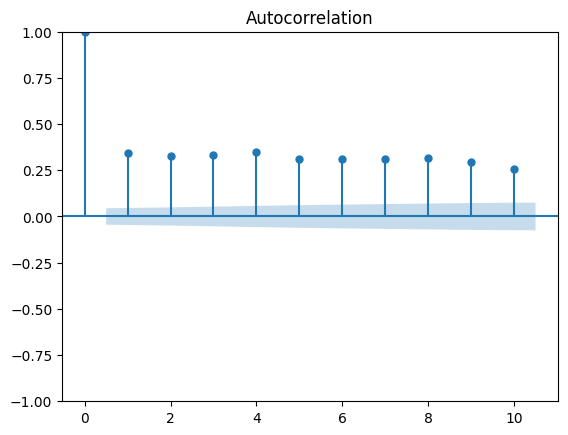

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


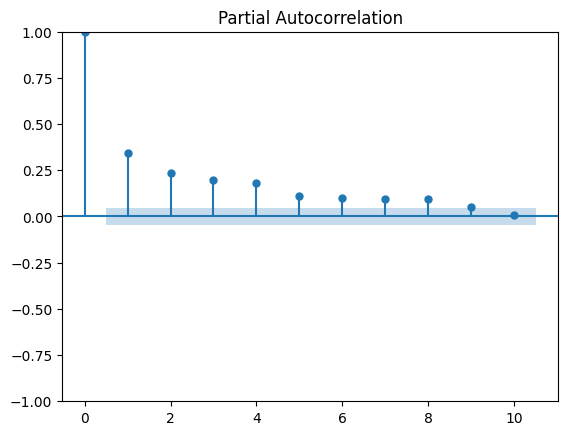

In [ ]:
sm.graphics.tsa.plot_acf(df_clean, lags=10)
plt.show()

sm.graphics.tsa.plot_pacf(df_clean, lags=10)
plt.show()

In [ ]:
p,d,q = 1,0,1
model = ARIMA(df_clean, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1951
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14129.919
Date:                Thu, 27 Apr 2023   AIC                          28267.837
Time:                        14:56:21   BIC                          28290.142
Sample:                             0   HQIC                         28276.037
                               - 1951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1573.9315     77.464     20.318      0.000    1422.104    1725.759
ar.L1          0.9863      0.005    200.719      0.000       0.977       0.996
ma.L1         -0.8750      0.012    -70.060      0.0

In [ ]:
train_size = int(len(df_clean) * 0.85)
train, test = df_clean.iloc[:train_size], df_clean.iloc[train_size:]
# from pmdarima.arima import auto_arima
# model = auto_arima(train, trace=True,  suppress_warnings=True)
# predictions = model.predict(n_periods=len(test))
# plt.plot(test, color='green')
# plt.plot(train)
# plt.plot(predictions, color='red')
# plt.show()

ARIMA being a complex model is being overfitted to the data in the auto_arima api model as the data we have is very less for such a complex model


# Moving Average Forecast model

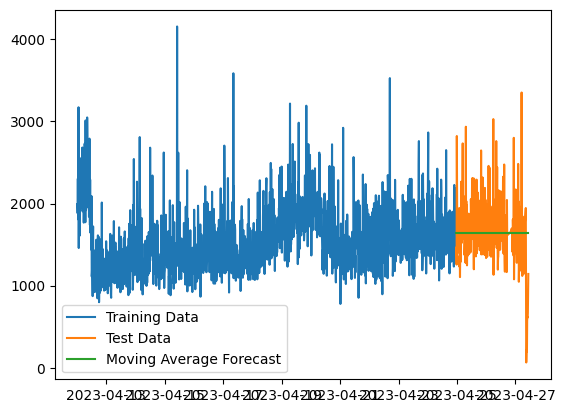

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

# Moving Averag8 (MA) model
window_size = 72
ma_predictions = test.copy()
ma_predictions['forecast'] = train['y'].rolling(window_size).mean().iloc[-1]
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(ma_predictions['forecast'], label='Moving Average Forecast')
plt.legend()
plt.show()

 # Exponential Smoothing model

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


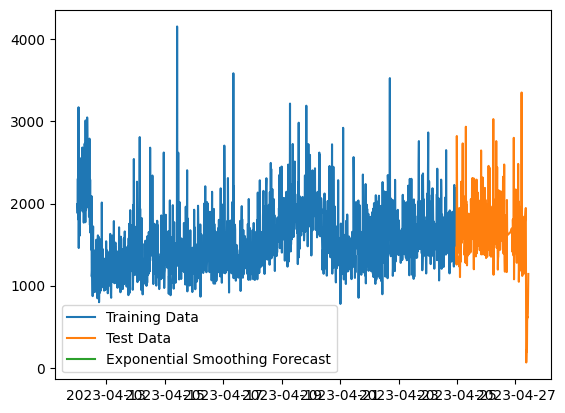

In [ ]:
alpha = 0.2 # smoothing constant
es_model = SimpleExpSmoothing(train['y']).fit(smoothing_level=alpha)
es_predictions = test.copy()
es_predictions['forecast'] = es_model.forecast(len(test))
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(es_predictions['forecast'], label='Exponential Smoothing Forecast')
plt.legend()
plt.show()


# LSTM model

In [ ]:
f.set_test_length(30)       # 1. 30 observations to test the results
f.generate_future_dates(50) # 2. 50 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

60/60 [==============================] - 0s 2ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

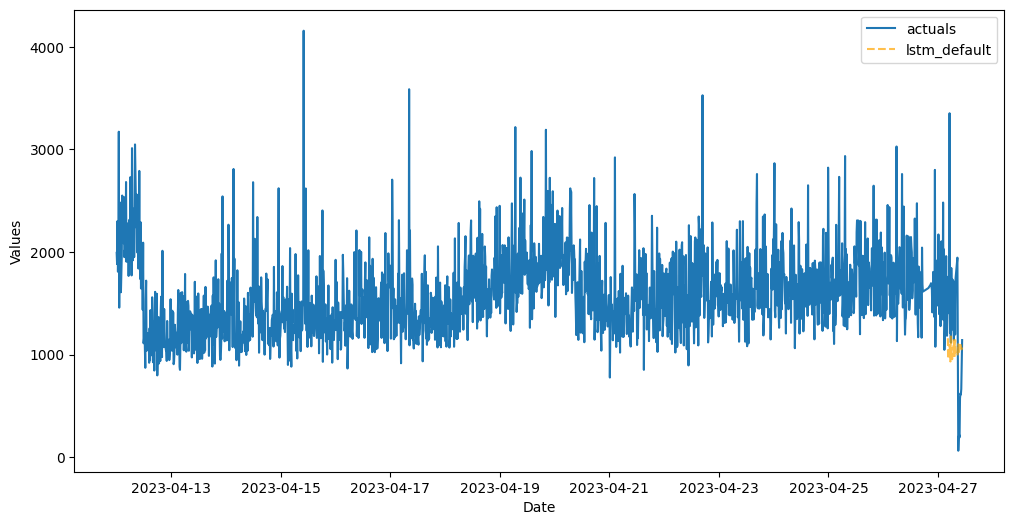

In [ ]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

<Axes: xlabel='Date', ylabel='Values'>

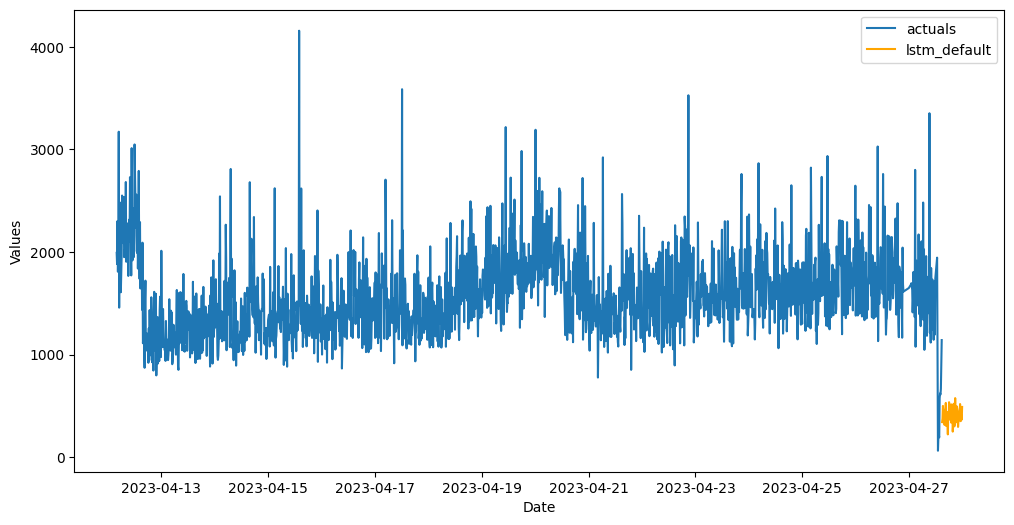

In [ ]:
f.plot()

59/59 [==============================] - 0s 4ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

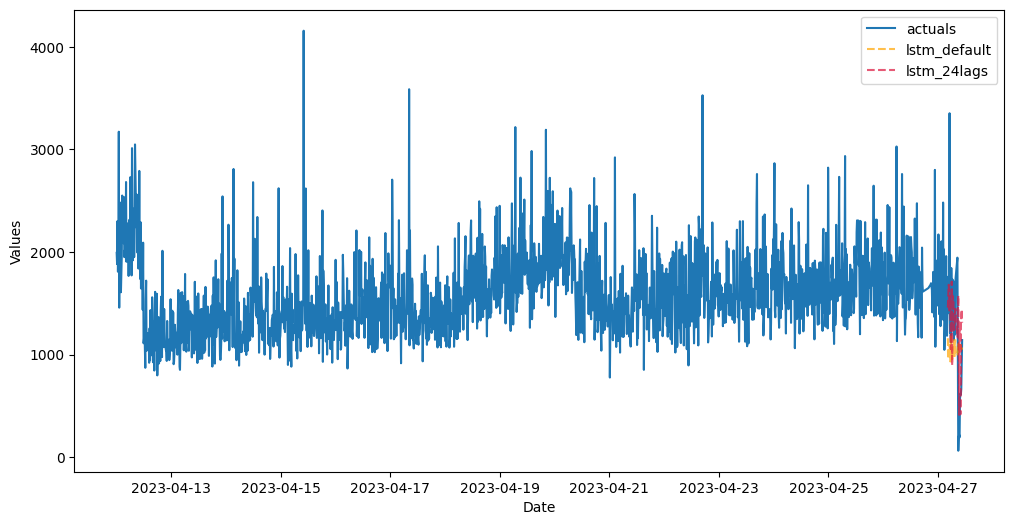

In [ ]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

Epoch 1/15
47/47 [==============================] - 3s 27ms/step - loss: 0.1635 - val_loss: 0.1224
Epoch 2/15
47/47 [==============================] - 1s 14ms/step - loss: 0.0917 - val_loss: 0.0795
Epoch 3/15
47/47 [==============================] - 1s 13ms/step - loss: 0.0798 - val_loss: 0.0761
Epoch 4/15
47/47 [==============================] - 1s 13ms/step - loss: 0.0782 - val_loss: 0.0758
Epoch 5/15
47/47 [==============================] - 1s 14ms/step - loss: 0.0774 - val_loss: 0.0736
Epoch 6/15
47/47 [==============================] - 1s 14ms/step - loss: 0.0772 - val_loss: 0.0743
Epoch 7/15
47/47 [==============================] - 1s 14ms/step - loss: 0.0771 - val_loss: 0.0734
Epoch 8/15
47/47 [==============================] - 1s 13ms/step - loss: 0.0770 - val_loss: 0.0737
Epoch 9/15
47/47 [==============================] - 1s 13ms/step - loss: 0.0770 - val_loss: 0.0734
Epoch 10/15
47/47 [==============================] - 1s 14ms/step - loss: 0.0768 - val_loss: 0.0750
Epoch 11/

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

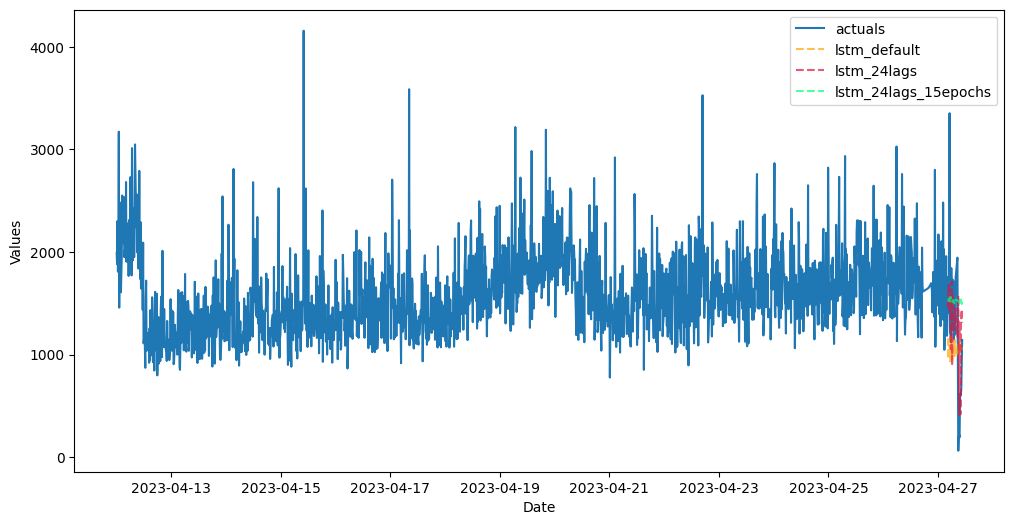

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_15epochs',
    lags=24,
    epochs=15,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

Epoch 1/25
47/47 [==============================] - 11s 66ms/step - loss: 0.1460 - val_loss: 0.1038
Epoch 2/25
47/47 [==============================] - 2s 39ms/step - loss: 0.0830 - val_loss: 0.0743
Epoch 3/25
47/47 [==============================] - 3s 57ms/step - loss: 0.0773 - val_loss: 0.0740
Epoch 4/25
47/47 [==============================] - 2s 43ms/step - loss: 0.0777 - val_loss: 0.0737
Epoch 5/25
47/47 [==============================] - 2s 39ms/step - loss: 0.0771 - val_loss: 0.0743
Epoch 6/25
47/47 [==============================] - 2s 39ms/step - loss: 0.0768 - val_loss: 0.0739
Epoch 7/25
47/47 [==============================] - 2s 40ms/step - loss: 0.0766 - val_loss: 0.0735
Epoch 8/25
47/47 [==============================] - 2s 40ms/step - loss: 0.0767 - val_loss: 0.0740
Epoch 9/25
47/47 [==============================] - 2s 45ms/step - loss: 0.0765 - val_loss: 0.0760
Epoch 10/25
47/47 [==============================] - 3s 54ms/step - loss: 0.0767 - val_loss: 0.0737
Epoch 11

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

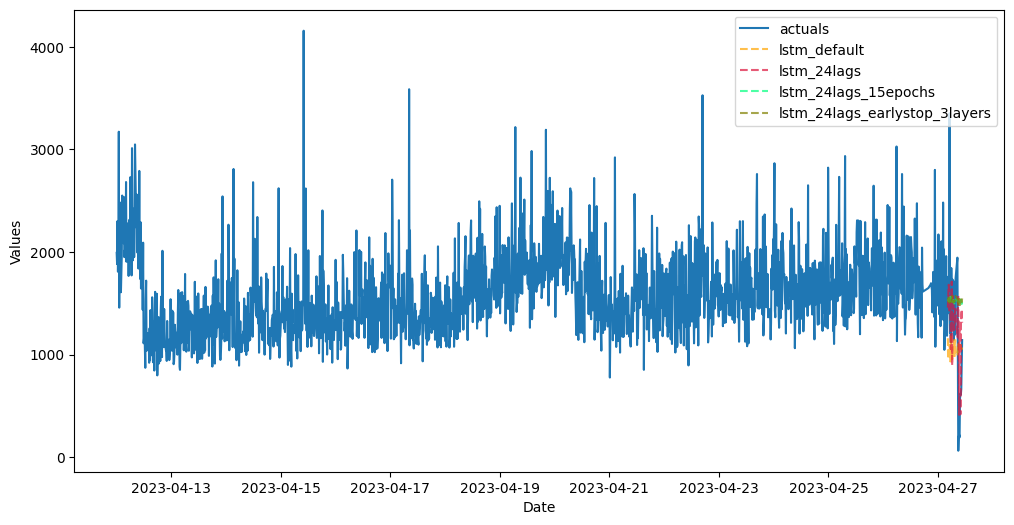

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',               
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0.1,0),
)

f.plot_test_set(ci=True)

# USING LASER VALUE DIFFERENCE FOR PREDICTION

In [ ]:
dates = pd.to_datetime(bm1.d_dt)[:-40]
values = (moving_average(bm1.on, 40) - moving_average(bm1.off, 40))[:-40]
df = pd.DataFrame({'ds': dates, 'y': values})

#### filtering out data before 12th April
start_date = "2023-04-12"
mask = (df['ds'] > start_date)
df_clean = df.loc[mask]

df_clean['ds'] = pd.to_datetime(df_clean['ds'])
df_clean = df_clean.set_index('ds')

<ipython-input-73-1431f156241c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ds'] = pd.to_datetime(df_clean['ds'])


In [ ]:
f = Forecaster(
    y = df_clean['y'],
    current_dates= df_clean.index,
    freq='11T'
)

f

Forecaster(
    DateStartActuals=2023-04-12T04:08:33.000000000
    DateEndActuals=2023-04-27T05:51:26.000000000
    Freq=11T
    N_actuals=1911
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [ ]:
## Augmented Dickey Fullers Test
stat, pval, _, _, _, _ = f.adf_test()
print(f'Stat: {stat}')
print(f'P-value: {pval}')

Stat: -3.770879915574549
P-value: 0.0032197053215783844


P-value is less than 0.05, timeseries can be assumed stationary

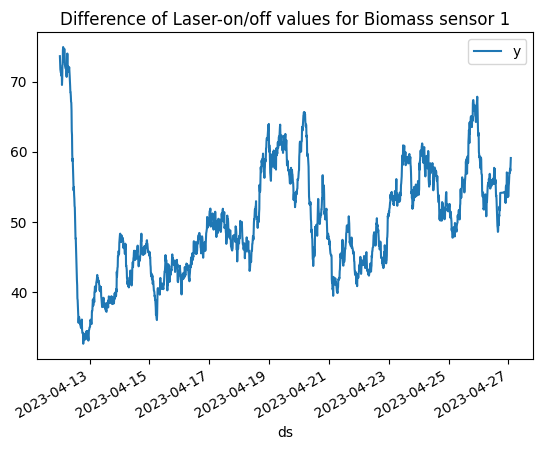

In [ ]:
df_clean.plot()
plt.title("Difference of Laser-on/off values for Biomass sensor 1")
plt.show()

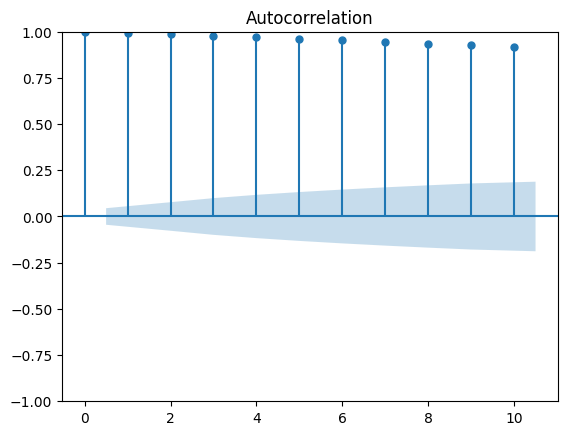

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


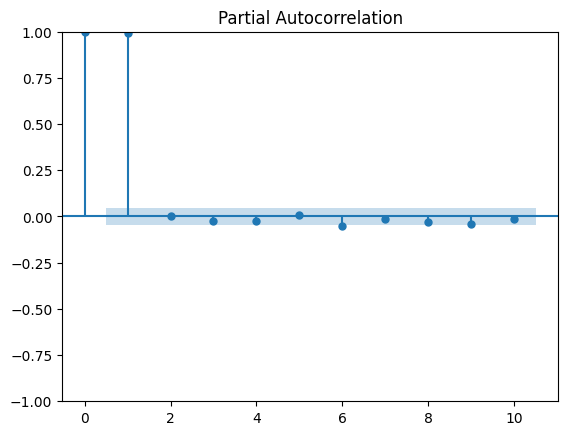

In [ ]:
sm.graphics.tsa.plot_acf(df_clean, lags=10)
plt.show()

sm.graphics.tsa.plot_pacf(df_clean, lags=10)
plt.show()



In [ ]:
p,d,q = 1,0,0
model = ARIMA(df_clean, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1911
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2261.120
Date:                Thu, 27 Apr 2023   AIC                           4528.239
Time:                        16:37:01   BIC                           4544.905
Sample:                             0   HQIC                          4534.373
                               - 1911                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.0612      4.160     12.997      0.000      45.908      62.214
ar.L1          0.9968      0.002    575.258      0.000       0.993       1.000
sigma2         0.6224      0.013     46.849      0.0

In [ ]:
### creating train-test sets
train_size = int(len(df_clean) * 0.85)
train, test = df_clean.iloc[:train_size], df_clean.iloc[train_size:]

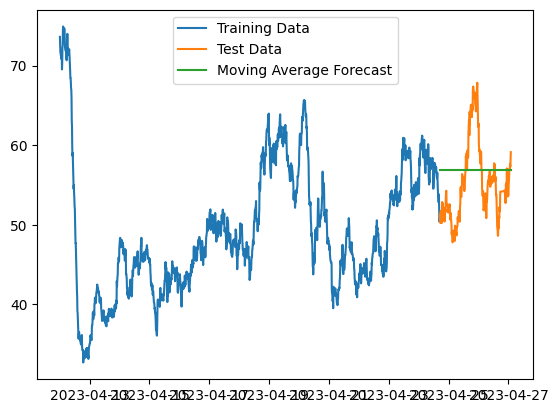

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

# Moving Averag8 (MA) model
window_size = 72
ma_predictions = test.copy()
ma_predictions['forecast'] = train['y'].rolling(window_size).mean().iloc[-1]
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(ma_predictions['forecast'], label='Moving Average Forecast')
plt.legend()
plt.show()

In [ ]:
df

,ds,y
0,2023-03-29 13:20:15-04:00,-0.475
1,2023-03-29 13:31:20-04:00,-0.500
2,2023-03-29 13:42:26-04:00,-0.525
3,2023-03-29 13:53:38-04:00,-0.550
4,2023-03-29 14:04:45-04:00,-0.575
...,...,...
3563,2023-04-27 01:06:46-04:00,57.375
3564,2023-04-27 01:17:54-04:00,57.600
3565,2023-04-27 01:29:11-04:00,57.275
3566,2023-04-27 01:40:19-04:00,58.150


Epoch 1/25
46/46 [==============================] - 10s 65ms/step - loss: 0.2572 - val_loss: 0.2421
Epoch 2/25
46/46 [==============================] - 2s 37ms/step - loss: 0.1188 - val_loss: 0.1023
Epoch 3/25
46/46 [==============================] - 2s 36ms/step - loss: 0.0823 - val_loss: 0.0750
Epoch 4/25
46/46 [==============================] - 2s 55ms/step - loss: 0.0772 - val_loss: 0.0732
Epoch 5/25
46/46 [==============================] - 2s 46ms/step - loss: 0.0750 - val_loss: 0.0734
Epoch 6/25
46/46 [==============================] - 3s 56ms/step - loss: 0.0730 - val_loss: 0.0731
Epoch 7/25
46/46 [==============================] - 2s 38ms/step - loss: 0.0714 - val_loss: 0.0886
Epoch 8/25
46/46 [==============================] - 2s 38ms/step - loss: 0.0736 - val_loss: 0.0692
Epoch 9/25
46/46 [==============================] - 2s 37ms/step - loss: 0.0680 - val_loss: 0.0681
Epoch 10/25
46/46 [==============================] - 2s 42ms/step - loss: 0.0672 - val_loss: 0.0711
Epoch 11

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

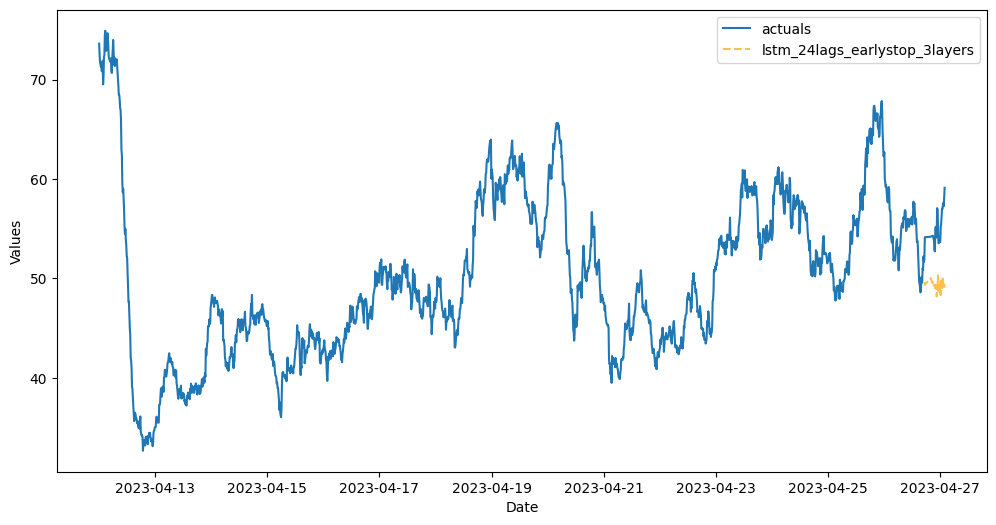

In [ ]:
#### LSTM
f.set_test_length(30)       # 1. 30 observations to test the results
f.generate_future_dates(50) # 2. 50 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',               
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0.1,0),
)

f.plot_test_set(ci=True)

Epoch 1/15
46/46 [==============================] - 4s 35ms/step - loss: 0.3155 - val_loss: 0.3758
Epoch 2/15
46/46 [==============================] - 1s 21ms/step - loss: 0.1724 - val_loss: 0.1847
Epoch 3/15
46/46 [==============================] - 1s 18ms/step - loss: 0.1047 - val_loss: 0.1035
Epoch 4/15
46/46 [==============================] - 1s 14ms/step - loss: 0.0887 - val_loss: 0.0895
Epoch 5/15
46/46 [==============================] - 1s 13ms/step - loss: 0.0839 - val_loss: 0.0807
Epoch 6/15
46/46 [==============================] - 1s 14ms/step - loss: 0.0824 - val_loss: 0.0790
Epoch 7/15
46/46 [==============================] - 1s 14ms/step - loss: 0.0813 - val_loss: 0.0784
Epoch 8/15
46/46 [==============================] - 2s 37ms/step - loss: 0.0809 - val_loss: 0.0775
Epoch 9/15
46/46 [==============================] - 1s 14ms/step - loss: 0.0801 - val_loss: 0.0759
Epoch 10/15
46/46 [==============================] - 1s 14ms/step - loss: 0.0787 - val_loss: 0.0756
Epoch 11/

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

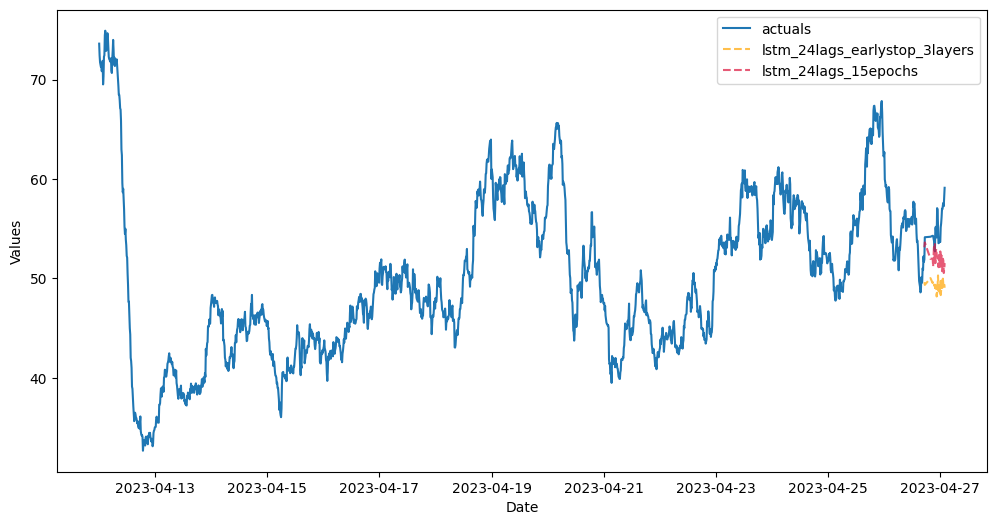

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_15epochs',
    lags=24,
    epochs=15,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

<Axes: xlabel='Date', ylabel='Values'>

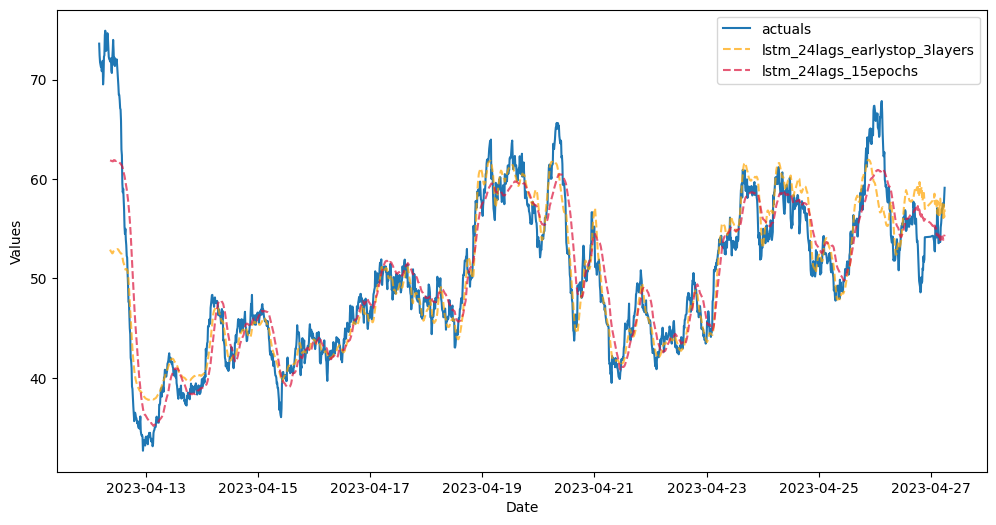

In [ ]:
f.plot_fitted()